In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def get_class_paths(path):
    classes = []  # List to store class labels
    class_paths = []  # List to store paths to images
    
    # Iterate over each label in the given directory
    for label in os.listdir(path):
        label_path = os.path.join(path, label)  # Construct the full path to the label directory
        
        if os.path.isdir(label_path):  # Check if the path is a directory
            # Iterate over each image in the label directory
            for img in os.listdir(label_path):
                img_path = os.path.join(label_path, img)  # Construct the full path to the image
                
                classes.append(label)  # Append the label to the classes list
                class_paths.append(img_path)  # Append the image path to the class_paths list
    
    # Create a DataFrame with the collected class paths and labels
    df = pd.DataFrame({
        'Class Path': class_paths,
        'Class': classes
    })
    return df  # Return the DataFrame

In [10]:
tr_df = get_class_paths('../data/Training')
tr_df

,Class Path,Class
0,../data/Training\glioma\Tr-glTr_0000.jpg,glioma
1,../data/Training\glioma\Tr-glTr_0001.jpg,glioma
2,../data/Training\glioma\Tr-glTr_0002.jpg,glioma
3,../data/Training\glioma\Tr-glTr_0003.jpg,glioma
4,../data/Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,../data/Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,../data/Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,../data/Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,../data/Training\pituitary\Tr-pi_1455.jpg,pituitary


In [11]:
ts_df = get_class_paths('../data/Testing')
ts_df

,Class Path,Class
0,../data/Testing\glioma\Te-glTr_0000.jpg,glioma
1,../data/Testing\glioma\Te-glTr_0001.jpg,glioma
2,../data/Testing\glioma\Te-glTr_0002.jpg,glioma
3,../data/Testing\glioma\Te-glTr_0003.jpg,glioma
4,../data/Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,../data/Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,../data/Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,../data/Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,../data/Testing\pituitary\Te-pi_0298.jpg,pituitary


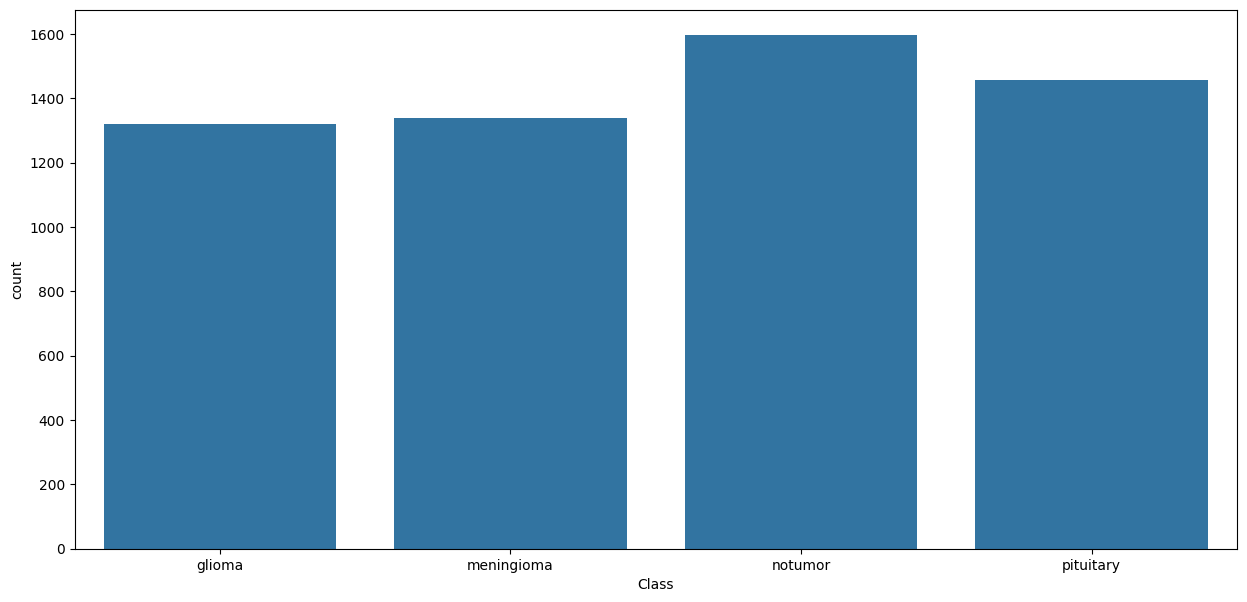

In [12]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(tr_df, x=tr_df['Class'])

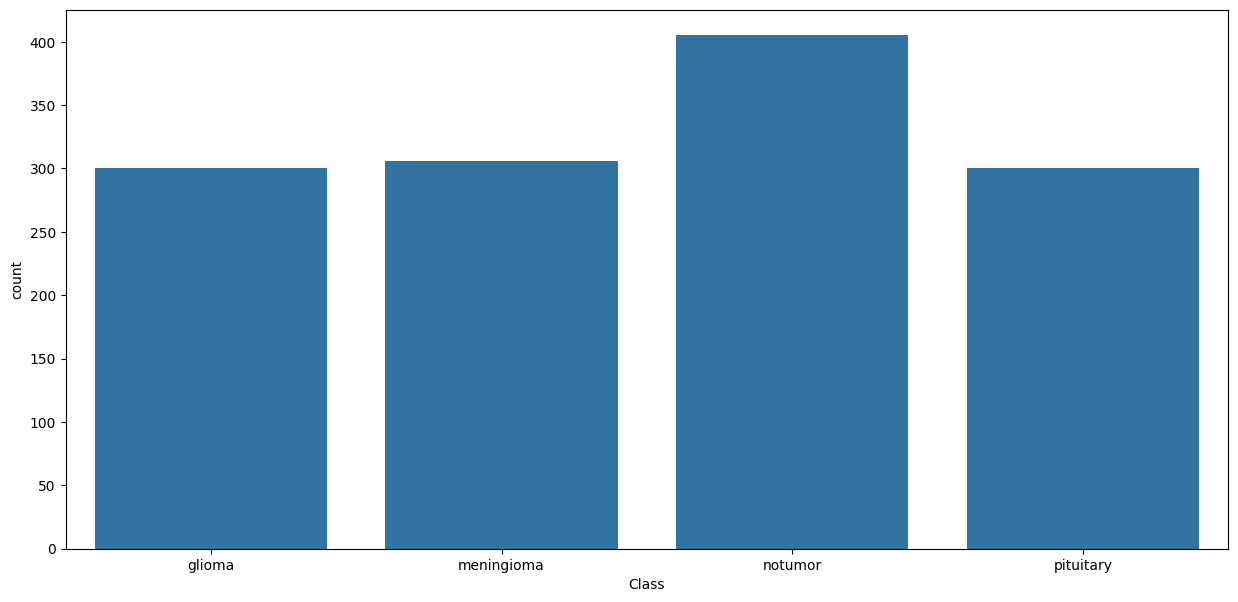

In [13]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(ts_df, x=ts_df['Class'])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch



In [6]:
torch.cuda.is_available()

False